# Assignment 1


Completed in 0.018273115158081055 seconds


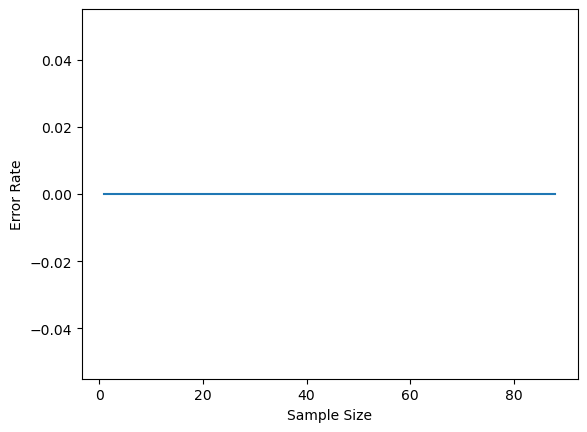

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
iris_label_space = np.array([0,1,2])

ion_X = np.genfromtxt("ionosphere.txt", delimiter=",", usecols=np.arange(34))
ion_y = np.genfromtxt("ionosphere.txt", delimiter=",", usecols=34, dtype="int")
ion_label_space = np.array([1,-1])

iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris['data'], iris['target'], random_state=2408)
ion_X_train, ion_X_test, ion_y_train, ion_y_test = train_test_split(ion_X, ion_y, random_state=2408)


def computeEuclideanNorm(vector: np.ndarray) -> float:
    """
        Computes the Euclidean norm of a vector by adding the squares of each value and square rooting
    """

    total = 0
    for i in range(0,vector.size):
        total += vector[i] * vector[i]
    
    return np.sqrt(total)


def calculateEuclideanDistance(v1: np.ndarray, v2: np.ndarray) -> float: 
    """
        Calculates the Euclidean distance between two points by computing the Euclidean norm of the vector distance
    """
    diff = np.subtract(v1, v2)
    return (computeEuclideanNorm(diff))


def computeDistances(sample: np.ndarray, training_set: np.ndarray) -> np.ndarray:
    """
        Calculates the distances from the given sample to all other points
    """

    result = np.zeros(len(training_set))
    for i in range(0, len(training_set)):
        result[i] = calculateEuclideanDistance(sample, training_set[i])

    return result


def computeMinimum(a: np.ndarray):
    """
        Calculates the minimum value of an array and returns it, along with its index
    """

    current_min = np.inf
    min_index = np.inf
    for n in range(a.size):
        if current_min > a[n]:
            current_min = a[n]
            min_index = n
    
    return current_min, min_index


def computeMaximum(a: np.ndarray):
    """
        Calculates the maximum value of an array and returns it, along with its index
    """
    current_max = -np.inf
    max_index = -np.inf
    for i in range(a.size):
        if current_max < a[i]:
            current_max = a[i]
            max_index = i

    return current_max, max_index

"""
# OLD IMPLEMENTATION
def calculateNNs(sample_X: np.ndarray, sample_y: np.ndarray, X_training_set: np.ndarray, y_training_set: np.ndarray):
    nn_dist_same = np.inf
    nn_index_same = np.inf
    nn_dist_diff = np.inf
    nn_index_diff = np.inf

    for i in range(0,len(X_training_set)):
        if y_training_set[i] == sample_y:
            d = calculateEuclideanDistance(sample_X, X_training_set[i])
            if d < nn_dist_same:
                nn_dist_same = d
                nn_index_same = i
        else:
            d = calculateEuclideanDistance(sample_X, X_training_set[i])
            if d < nn_dist_diff:
                nn_dist_diff = d
                nn_index_diff = i

    # print("Nearest (same):", X_training_set[nn_index_same], "Class:", y_training_set[nn_index_same], "Distance:", nn_dist_same)
    # print("Nearest (diff):", X_training_set[nn_index_diff], "Class:", y_training_set[nn_index_diff], "Distance:", nn_dist_diff)

    return nn_dist_same, nn_index_same, nn_dist_diff, nn_index_diff
"""
# IMPROVED CALCULATE NNs

def calculateNNs(index: int, sample_y: int, y_training_set: np.ndarray, distances: np.ndarray):
    """
        Calculate the nearest numbers by taking in a matrix of distances
    """
    nn_dist_same = np.inf
    nn_index_same = -1
    nn_dist_diff = np.inf
    nn_index_diff = -1

    for i in range(len(y_training_set)):
        if i == index:
            continue  # skip comparing sample to itself

        dist = distances[index][i]

        if y_training_set[i] == sample_y:
            if dist < nn_dist_same:
                nn_dist_same = dist
                nn_index_same = i
        else:
            if dist < nn_dist_diff:
                nn_dist_diff = dist
                nn_index_diff = i

    return nn_dist_same, nn_index_same, nn_dist_diff, nn_index_diff

def calculateConformityScores(sample_X: np.ndarray, sample_y: np.ndarray, X_training_set, y_training_set):
    """
        Calculates the conformity score of a sample, using the NN of the same class / NN of diffetebt class
    """
    X_aug = np.concatenate((sample_X.reshape(1, -1), X_training_set), axis=0)
    y_aug = np.concatenate(([sample_y], y_training_set)) # additional sample will be the FIRST in augmented set

    n = len(X_aug)
    scores = np.zeros(len(X_aug))

    distances = np.zeros((n, n))
    for i in range(0, n):
        for j in range(i + 1, n):
            dist = calculateEuclideanDistance(X_aug[i], X_aug[j])
            distances[i][j] = dist
            distances[j][i] = dist

    for i in range(0, n):
        nn_dist_same, _, nn_dist_diff, _ = calculateNNs(i, y_aug[i], y_aug, distances)
        
        if nn_dist_same == 0:
            if nn_dist_diff == 0:
                scores[i] = 0
            else:
                scores[i] = np.inf
        else:
            scores[i] =  nn_dist_diff / nn_dist_same

    """
    # OLD IMPLEMENTATION
    for i in range(0, len(y_aug)):
        X_new = np.delete(X_aug, i, axis=0)
        y_new = np.delete(y_aug, i)
        nn_dist_same, _, nn_dist_diff, _ = calculateNNs(X_aug[i], y_aug[i], X_new, y_new)
        conformity_score = 0
        if nn_dist_same == 0:
            if nn_dist_diff == 0:
                conformity_score = 0
            else:
                conformity_score = np.inf
        else:
            conformity_score =  nn_dist_diff / nn_dist_same

        scores[i] = conformity_score
    """
    return scores


def calculatePValue(scores):
    """
        Calculate a given p-value given the conformity scores
    """
    test_score = scores[0]
    other_scores = scores[1:]

    rank = 0
    for score in other_scores:
        if score <= test_score:
            rank += 1

    p_value = (rank + 1) / len(scores)
    return p_value


def predict(Y, sample_X, X_training_set, y_training_set):
    """
        Makes a prediction by computing p-values of all possible labels and selecting the highest one
    """

    Y_size = len(Y)
    p_values = np.zeros(Y_size)
    for i in range (0, Y_size):
        label = Y[i]
        scores = calculateConformityScores(sample_X, label, X_training_set, y_training_set)
        p_values[i] = calculatePValue(scores)

    _, p = computeMaximum(p_values)

    return Y[p]


def score(predictions, y_test_set):
    """
        Score the prediction set against the set of actual labels
    """
    return np.mean(predictions == y_test_set)



start = time.time()

X_train_set = ion_X_train
y_train_set = ion_y_train
X_test_set = ion_X_test
y_test_set = ion_y_test
Y = ion_label_space

sample_sizes = np.arange(1, len(X_test_set) + 1)
error_rates = np.zeros_like(sample_sizes, dtype=float)
"""
for i, size in enumerate(sample_sizes):
    current_X_test = X_test_set[:size]
    current_y_test = y_test_set[:size]
    current_predictions = np.zeros(size)

    for j in range(size):
        current_predictions[j] = predict(Y, current_X_test[j], X_train_set, y_train_set)
    
    s = score(current_predictions, current_y_test)
    error_rates[i] = 1 - s
    print("Progress: {:.2f}%".format(((i+1)/sample_sizes.size) * 100), end="\r")
"""
plt.plot(sample_sizes, error_rates)
plt.xlabel('Sample Size')
plt.ylabel('Error Rate')
print("\nCompleted in", time.time() - start, "seconds")

In [4]:
iris_predictions = np.zeros(len(iris_X_test))
for i in range(0, len(iris_X_test)):
    iris_predictions[i] = predict(iris_label_space, iris_X_test[i], iris_X_train, iris_y_train)

score(iris_predictions, iris_y_test)

0.9736842105263158

In [5]:
ion_predictions = np.zeros(len(ion_X_test))
for j in range(0, len(ion_X_test)):
    ion_predictions[j] = predict(ion_label_space, ion_X_test[i], ion_X_train, ion_y_train)

score(ion_predictions, ion_y_test)

0.6136363636363636